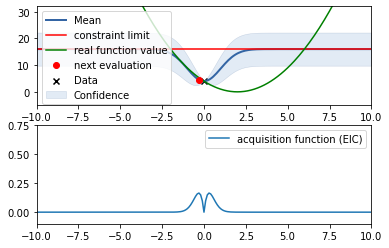

optimizer  [-0.30815743]  found with EIC  0.16459100114337383


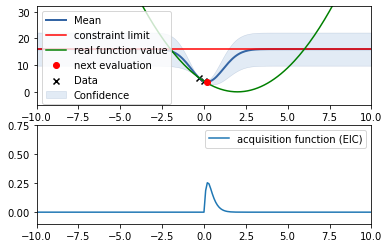

optimizer  [0.22943239]  found with EIC  0.255973187108556


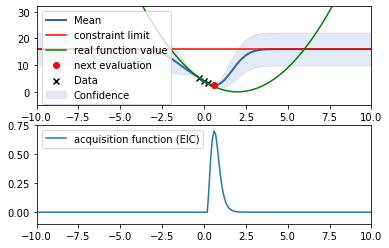

optimizer  [0.61451636]  found with EIC  0.7008533200679586


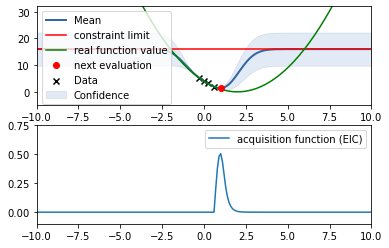

optimizer  [0.97424178]  found with EIC  0.506128787261018


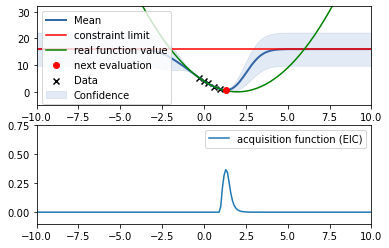

optimizer  [1.31836156]  found with EIC  0.36694800276834877


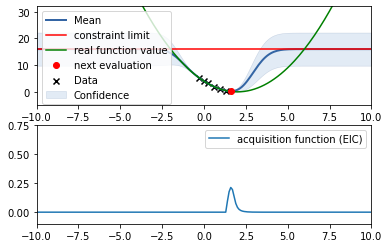

optimizer  [1.61998228]  found with EIC  0.213458634892103


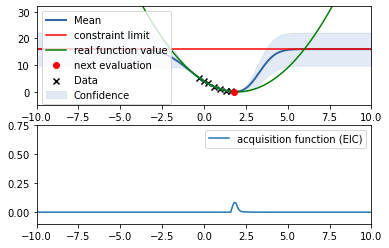

optimizer  [1.8446156]  found with EIC  0.08675415204541193


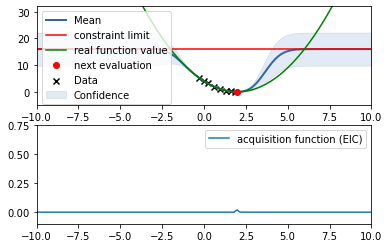

optimizer  [1.97298566]  found with EIC  0.019763005077402453


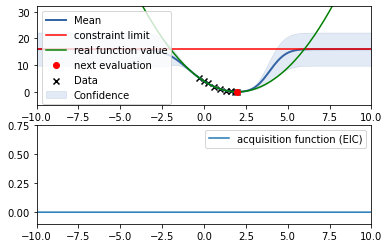

optimizer  [1.99832782]  found with EIC  0.0006566701492456981
the optimal cost value  [2.79618745e-06] was found at input  [1.99832782]
The number of constraint violations was  0
violations at  []
with constraint values []
the optimization has evaluated  0  repetitions
the best prediction was found at:  [1.31836156]
with mean cost value,  [0.46462219]
and std,  [0.00010844]


In [1]:
"""
2D optimization via constrained Bayesian optimization using the CBOopt object of CBOopt.py on two arbitrary
mathematical functions used as cost and constraint (con1)
"""
import numpy as np
import GPy
import datetime
import CBOopt
import matplotlib

# Cost and constraint function
def cost(x):
    return (x-2)**2

if __name__ == '__main__':
    # Bayesian optimization parameters
    dim_x = 1 # optimizazion dimension
    beta = 2 # confidence parameter (default = 3 ~99% confidence)
    d_min = np.array([-10]) # domain lower bound
    d_max = np.array([10]) # domain upper bound
    discretization = np.array([0.1])
    x_sample = np.linspace(-10, 10, num=201)
    d_min_safe = np.array([-2])
    d_max_safe = np.array([6])
    iterlim = 10 # max number of iterations
    constrlim = np.array([16]) # constraint limit (if the cost itself is not constrained use None)
    std_limit = 1e-6
    stop_eic_abs = 0.01 # EIC termination level
    init = CBOopt.LHCsample(1, dim_x, d_min_safe, d_max_safe)
    # init = np.array([[0]])
    filename = "CBOoptimization"
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M') # Time stamp for data storage
    optimization_method = "PSO"
    update_hyperparameters_flag = False
    safe_flag = True

    # Evaluate initial set
    samples = init.copy()
    val = cost(samples[0])
    values = np.array([val])
    for i in range(1,samples.shape[0]):
        val = cost(samples[i])
        values = np.vstack((values,val))

    # Build up GP(s) for cost function and additional constraints
    # GP kernel
    RBF = GPy.kern.RBF(input_dim=dim_x, lengthscale=[1], variance=10) # squared exponential kernel (k(x,x'))
    RBF.lengthscale.constrain_bounded(0.1, 10, warning=False) # lengthscale bounds for hyperparameter tuning
    RBF.variance.constrain_bounded(0.1, 10, warning=False) # variance bounds for hyperparameter tuning

    # Prior mean constant
    mf_gp0 = GPy.mappings.Constant(dim_x, 1, constrlim[0])  # prior mean (constant mean prior mu_0(x))

    # Prior mean function handle
    # mf_gp0 = GPy.core.Mapping(dim_x, 1)
    # mf_gp0.f = cost
    # mf_gp0.update_gradients = lambda a, b: None

    # cost GP
    gp0 = GPy.core.GP(samples, values,
                      RBF, GPy.likelihoods.Gaussian(variance=1e-9), mean_function=mf_gp0)

    # GoOSE main
    # create GoOSE instance
    gps = [gp0]
    opt = CBOopt.CBOopt(gps, constrlim, d_min, d_max, optimization_method, stop_eic_abs=stop_eic_abs)
    #opt.update_hyperparameters()
    i = values.shape[0] # current iteration

    while i < iterlim and opt.stopcount < 3:
        # plot GP
        fig, (ax1, ax2) = matplotlib.pyplot.subplots(2, 1)
        plt = opt.gps[0].plot(plot_limits=[d_min[0], d_max[0]], ax=ax1)
        ax1.plot(x_sample, constrlim[0] * np.ones(len(x_sample)), color="r", label="constraint limit")
        ax1.plot(x_sample, cost(x_sample), color="g", label="real function value")
        ax1.set_ylim([-5, 2*constrlim[0]])
        # plot acquisition function
        EIC_t = opt.EIC(np.expand_dims(x_sample, axis=1))
        ax2.plot(x_sample, EIC_t,label="acquisition function (EIC)")
        ax2.set_xlim([d_min[0], d_max[0]])
        ax2.set_ylim([-0.1, 0.75])
        # plot next point to evaluate
        i_next = np.argmax(EIC_t)
        EIC_next = EIC_t[i_next]
        mean_next, var_next = opt.gps[0].predict(np.atleast_2d(x_sample[i_next]))
        mean_next = mean_next.squeeze()
        ax1.plot(x_sample[i_next], mean_next, "ro",label="next evaluation")
        # plot show
        ax1.legend()
        ax2.legend()
        matplotlib.pyplot.show(block=False)
        matplotlib.pyplot.pause(5)
        matplotlib.pyplot.close()

        # Calculate optimizer
        if optimization_method == "PSO":
            x_opt, eic = opt.get_optimizer_PSO(20*dim_x)
        elif optimization_method == "grid evaluation":
            x_opt, eic = opt.get_optimizer_grideval(discretization)
        else:
            raise NotImplementedError("undefined optimization method")
        print("optimizer ", x_opt, " found with EIC ", eic)
        # Evaluate optimizer
        val = cost(x_opt)
        y = np.array([val[0]])
        opt.add_new_data_point(x_opt,y)
        if update_hyperparameters_flag is True:
            opt.update_hyperparameters()
        i = i+1

    # Results
    # All valid points fulfilling the constraints, boolean array
    valid_points = np.all(opt.y[:,opt.flag_mainc:] < opt.constrlim[opt.flag_mainc:],axis=1)
    # Optimal cost of valid evaluated points
    optimal_observed_value = opt.best
    # Optimal iteration
    optimal_i = opt.best_idx
    # All valid input parameters evaluated
    valid_inputs = opt.x[valid_points==1,:]
    # Best input parameters evaluated
    optimal_input = valid_inputs[optimal_i,:]
    # Number of infeasible evaluations (violation of at least 1 constraint)
    num_if_points = opt.y.shape[0] - valid_inputs.shape[0]
    # All invalid inputs
    invalid_inputs = opt.x[valid_points==0,:]
    # Observed constraint values of invalid inputs
    violations = opt.y[valid_points==0,opt.flag_mainc:]
    # Delete repetitions from inputs, to count them
    unique_inputs = np.unique(opt.x,axis=0)
    # Best prediction
    optimal_prediction_x, optimimal_prediction_mean, optimal_prediction_std = opt.get_best_prediction(direction=-1,
        constraint=lambda x: opt.get_posterior(x,0)[1] < std_limit, safe_set=opt.x)

    # Save results
    if safe_flag is True:
        opt.save_data(filename,timestamp,source=None,constraint=lambda x: opt.get_posterior(x,0)[1] < std_limit,safe_set=opt.x)

    print("the optimal cost value ",optimal_observed_value,"was found at input ",optimal_input)
    print("The number of constraint violations was ",num_if_points)
    print("violations at ",invalid_inputs)
    print("with constraint values",violations)
    print("the optimization has evaluated ", (opt.y.shape[0] - unique_inputs.shape[0]), " repetitions")
    print("the best prediction was found at: ", optimal_prediction_x)
    print("with mean cost value, ", optimimal_prediction_mean)
    print("and std, ", optimal_prediction_std)
